# Matching GPX to OSM data

Importing packages

In [1]:
from shapely.geometry import Point, LineString
import numpy as np
import rasterio
from rtree import index
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs
import xml.etree.ElementTree as ET
import gpxpy.gpx
from pyproj import CRS
from pyproj import Transformer

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\geopandas\_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Importing the network

In [27]:
raster_map = rasterio.open(
        os.path.join('OS Explorer Maps', 'Download_South+Dartmoor_2004150', 'raster-25k_4541337', 'sx', 'sx56.tif'))

In [3]:
road_links = gpd.read_file(os.path.join('OpenStreetMap', 'Dartmoor','highway_roads_Dartmoor_link.geojson'))
road_links = road_links.to_crs(27700)

road_nodes = gpd.read_file(os.path.join('OpenStreetMap', 'Dartmoor','highway_roads_Dartmoor_node.geojson'))
road_nodes = road_nodes.to_crs(27700)

path_links = gpd.read_file(os.path.join('OpenStreetMap', 'Dartmoor','highway_track_Dartmoor_link.geojson'))
path_links = path_links.to_crs(27700)

path_nodes = gpd.read_file(os.path.join('OpenStreetMap', 'Dartmoor','highway_track_Dartmoor_node.geojson'))
path_nodes = path_nodes.to_crs(27700)

Importing the gpx data

In [4]:
gpx_file = open(os.path.join('Walking routes', 'Bluebell walk.gpx'), 'r')

Creating the Network

In [5]:
def create_network(road_links, path_links):
    path_geom = [path for path in path_links['geometry']]
    road_geom = [road for road in road_links['geometry']]
    geom = path_geom + road_geom

    path_ids = [id for id in path_links['full_id']]
    road_ids = [id for id in road_links['full_id']]
    ids = path_ids + road_ids

    Dartmoor_links = gpd.GeoDataFrame({'fid': ids, 'geometry': geom})
    Dartmoor_links.plot()
    return Dartmoor_links

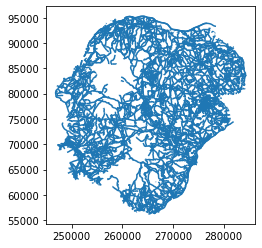

In [6]:
Dartmoor_links =  create_network(road_links, path_links)

Converting the gpx data

In [7]:
def import_gpx(gpx_file):
    gpx = gpxpy.parse(gpx_file)

    wsg84 = CRS.from_epsg(4326)
    osgb36 = CRS.from_epsg(27700)
    transformer = Transformer.from_crs(wsg84, osgb36)

    points = []
    if gpx.waypoints:
        waypoints = gpx.waypoints
    else:
        routes = gpx.routes
        waypoints = routes[0].points

    for waypoint in waypoints:
        points.append(transformer.transform(waypoint.latitude, waypoint.longitude))

    links = []
    first_point = points[0]
    for point in points[1:]:
        links.append(LineString([first_point,point]))
        first_point = point
    route_gpd = gpd.GeoSeries(links)
    route_gpd.plot()
    # route_gpd.plot()

    bounds = []
    for bound in gpx.bounds:
        bounds.append(bound)
    top_right = (transformer.transform(bounds[1], bounds[3]))
    bottom_left = (transformer.transform(bounds[0], bounds[2]))

    return route_gpd, points, top_right, bottom_left

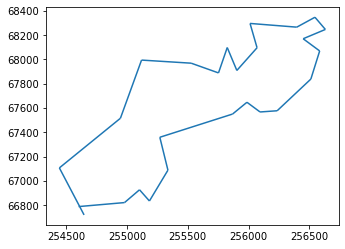

In [8]:
bluebell_walk,coords, top_right, bottom_left = import_gpx(gpx_file)

Finding the nearest link for the first coordinate

<AxesSubplot:>

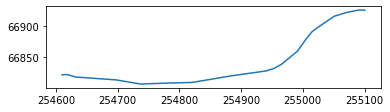

In [25]:
link = bluebell_walk[0]
idx = index.Index()

# set the bounds for the index
for i in range(len(Dartmoor_links['fid'])):
    left, bottom, right, top = (Dartmoor_links['geometry'][i].bounds[0], Dartmoor_links['geometry'][i].bounds[1],
                                    Dartmoor_links['geometry'][i].bounds[2], Dartmoor_links['geometry'][i].bounds[3])
    idx.insert(i, (left, bottom, right, top))

for i in idx.nearest(link.bounds, 1):
    first_coordinate = Dartmoor_links['geometry'][i]
    # need to add # so that it is identified in with the link
    first_link = Dartmoor_links['fid'][i]

line_gpd = gpd.GeoSeries(first_coordinate)
line_gpd.plot()

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


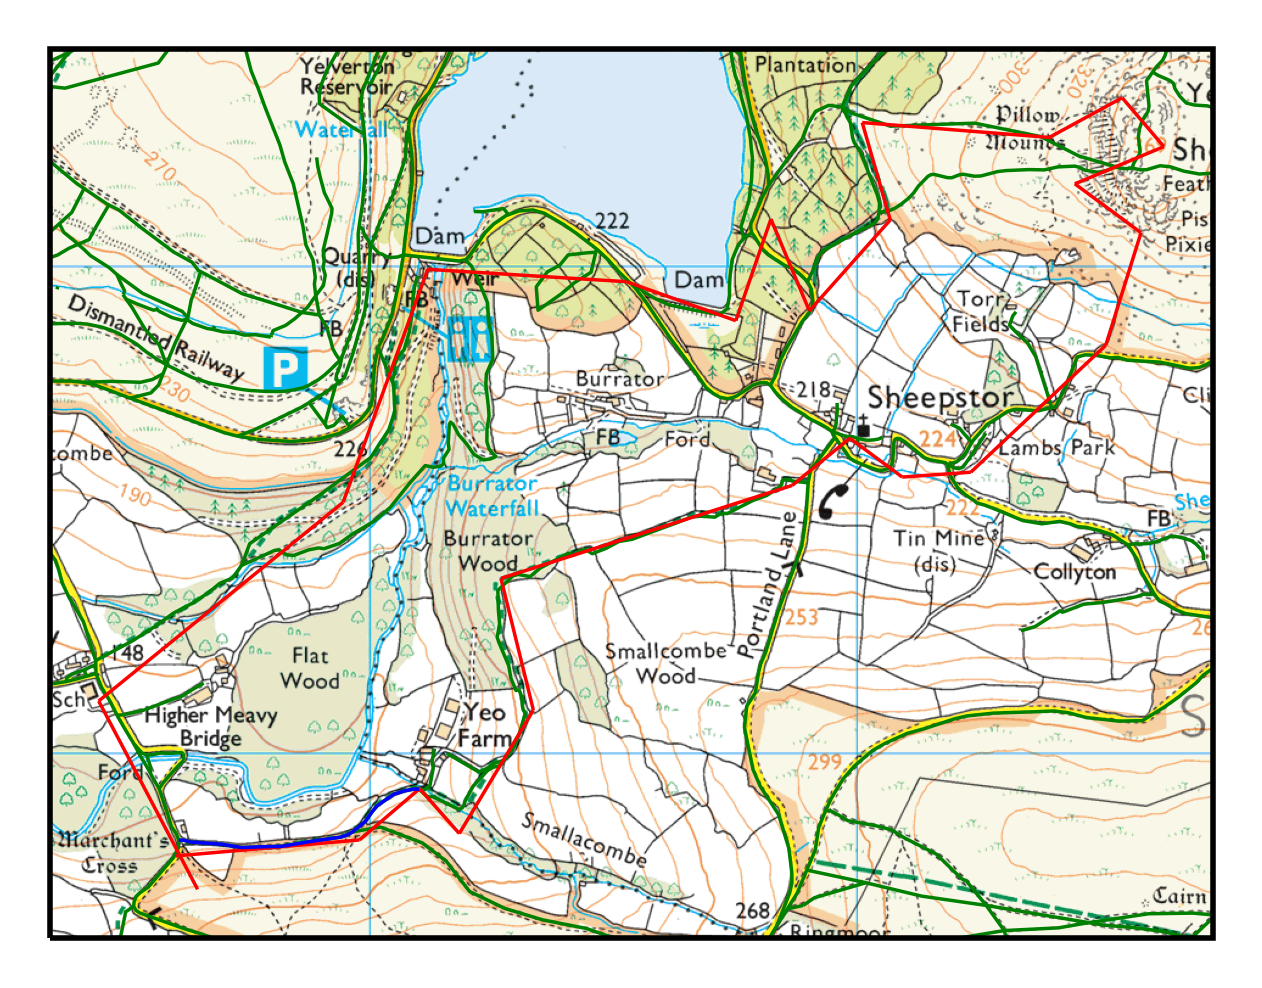

In [29]:
back_array = raster_map.read(1)
palette = np.array([value for key, value in raster_map.colormap(1).items()])
background_image = palette[back_array]
bounds = raster_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
fig = plt.figure(figsize=(3, 3), dpi=500)

ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

Dartmoor_links.plot(ax=ax, edgecolor='green', linewidth=0.5, zorder=1)
bluebell_walk.plot(ax=ax, edgecolor='red', linewidth=0.5, zorder=2)
line_gpd.plot(ax=ax, edgecolor='blue', linewidth=0.5, zorder=3)

display_extent = ((bottom_left[0] - 100, top_right[0] + 100,
                       bottom_left[1] - 100, top_right[1] + 100))
ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()

***

In [23]:
def get_nearest_links(Dartmoor_links,link):
    idx = index.Index()

    # set the bounds for the index
    for i in range(len(Dartmoor_links['fid'])):
        left, bottom, right, top = (Dartmoor_links['geometry'][i].bounds[0], Dartmoor_links['geometry'][i].bounds[1],
                                        Dartmoor_links['geometry'][i].bounds[2], Dartmoor_links['geometry'][i].bounds[3])
        idx.insert(i, (left, bottom, right, top))

    for i in idx.nearest(link.bounds, 1):
        first_coordinate = Dartmoor_links['geometry'][i]
        # need to add # so that it is identified in with the link
        first_link = Dartmoor_links['fid'][i]
        global_geom.append(first_coordinate)
        global_links.append(first_link)

    line_gpd = gpd.GeoSeries(first_coordinate)
    line_gpd.plot()

    return first_coordinate, first_link

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\geopandas\plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


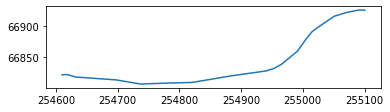

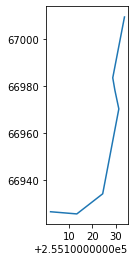

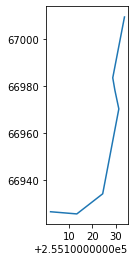

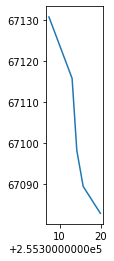

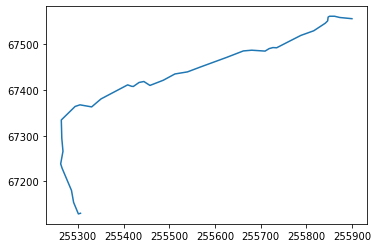

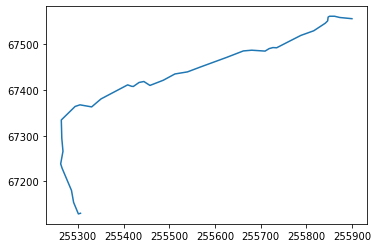

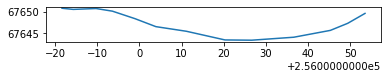

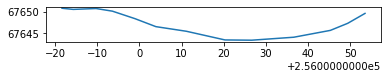

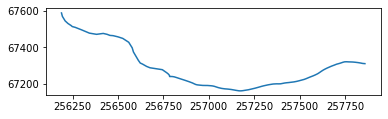

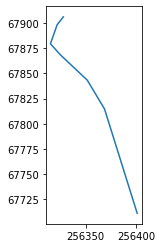

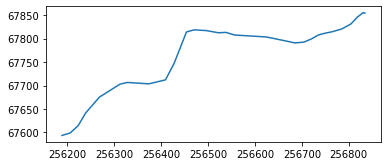

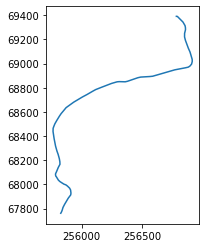

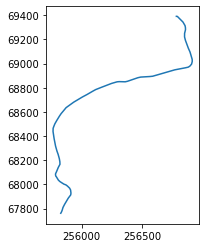

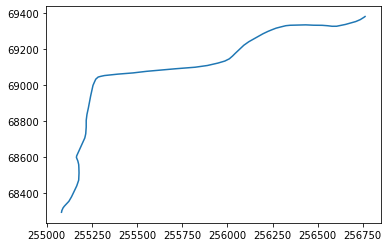

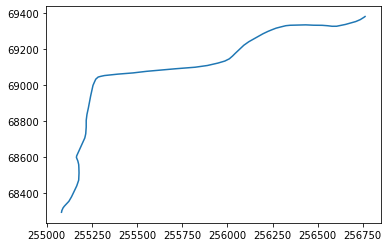

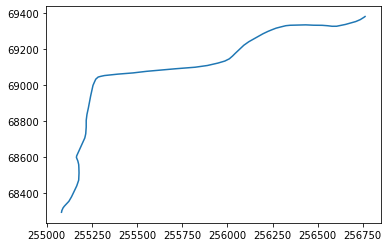

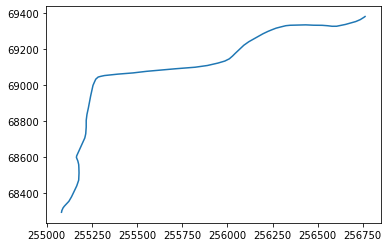

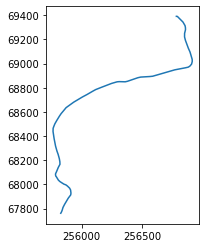

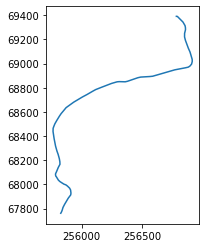

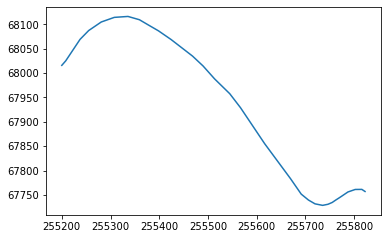

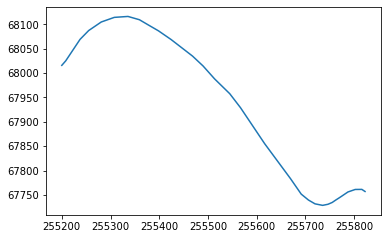

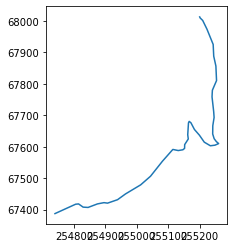

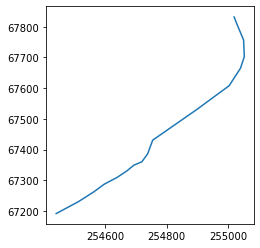

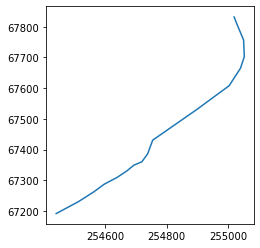

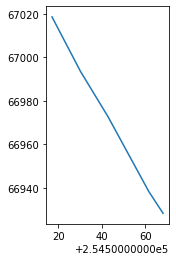

In [24]:
global_geom = []
global_links = []
for link in bluebell_walk:
    first_coordinate, first_link =get_nearest_links(Dartmoor_links,link)
global_path_gpd = gpd.GeoDataFrame({'fid': global_links, 'geometry': global_geom})

<AxesSubplot:>

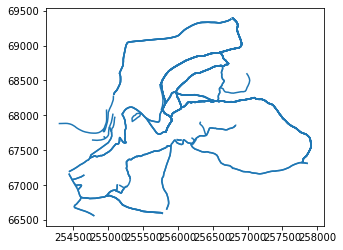

In [22]:
global_path_gpd.plot()

***

Converting gpx to path

In [9]:
def gpx_to_path(first_node, last_node, g, path_network, global_geom, global_links):
    path = nx.dijkstra_path(g, first_node, last_node, weight='weight')
    if len(path) != 1:
        geom = []
        links = []

        first_node = path[0]
        for node in path[1:]:
            link_fid = g.edges[first_node, node]['fid']
            links.append(link_fid)
            global_links.append(link_fid)
            row = path_network.loc[path_network['gml_id'] == link_fid]
            geom.append(row['geometry'].cascaded_union)
            global_geom.append(row['geometry'].cascaded_union)
            first_node = node

        path_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})
        # print('Plotting Path')
        # path_gpd.plot()
        return path_gpd

In [10]:
global_geom = []
global_links = []
global_missing_links = []
for link in bluebell_walk:
    first_coordinate, first_link = get_nearest_links(Dartmoor_links,link)
    path_gpd = gpx_to_path(first_node, last_node, g, path_network, global_geom, global_links)
    # plot_map(sheepstor_map, first_coordinate, last_coordinate, coords,
    #          bluebell_walk, path_network, path_nodes, path_gpd)
    start_point = coord
global_path_gpd = gpd.GeoDataFrame({'fid': global_links, 'geometry': global_geom})
# global_path_gpd.to_file("global_path_gpd")
global_nodes_gpd = gpd.GeoDataFrame({'geometry': global_nodes})

Finding the missing sections

In [11]:
def calculate_missing_sections(global_missing_links, path_gpd, points):
    missing_links = []
    path_geoseries = gpd.GeoSeries(path_gpd['geometry'])
    # account for missing nodes that are on the path due to being so small there nodes were the same
    for link in global_missing_links:
        if not any(path_geoseries.intersects(link)):
            missing_links.append(link)
    # global_missing_links_gpd = gpd.GeoSeries(global_missing_links)
    global_missing_links_gpd = gpd.GeoSeries(missing_links)
    # global_missing_links_gpd.to_file("global_missing_links_gpd")

    missing_length = ((len(global_missing_links_gpd) / (len(points) - 1))*100)
    print("Percentage of Path missing in network is", missing_length, "%")

    return global_missing_links_gpd

In [12]:
global_missing_links_gpd = calculate_missing_sections(global_missing_links, global_path_gpd, coords)

Percentage of Path missing in network is 12.0 %


Plot missing links

<AxesSubplot:>

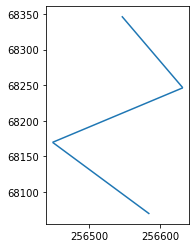

In [13]:
global_missing_links_gpd.plot()

Plot new path

In [14]:
def plot_global_map(raster_map, global_nodes_gpd, points,
                    route_gpd, path_network, path_nodes, path_gpd, top_right, bottom_left, global_missing_links_gpd):
    back_array = raster_map.read(1)
    palette = np.array([value for key, value in raster_map.colormap(1).items()])
    background_image = palette[back_array]
    bounds = raster_map.bounds
    extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
    fig = plt.figure(figsize=(3, 3), dpi=500)

    ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())
    ax.imshow(background_image, origin='upper', extent=extent, zorder=0)
    route_gpd.plot(ax=ax, edgecolor='blue', linewidth=0.5, zorder=2)
    plt.scatter(*zip(*points), color='blue', s=1, zorder=3)

    # path_network.plot(ax=ax, edgecolor='blue', linewidth=0.5, zorder=4)
    # path_nodes.plot(ax=ax, color='blue', markersize=1, zorder=4)

    global_missing_links_gpd.plot(ax=ax, color='red', linewidth=1, zorder=6)

    path_gpd.plot(ax=ax, edgecolor='green', linewidth=1, zorder=5)
    global_nodes_gpd.plot(ax=ax, color='yellow', markersize=1, zorder=5)

    display_extent = ((bottom_left[0] - 100, top_right[0] + 100,
                       bottom_left[1] - 100, top_right[1] + 100))
    ax.set_extent(display_extent, crs=crs.OSGB())
    plt.show()

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:25: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


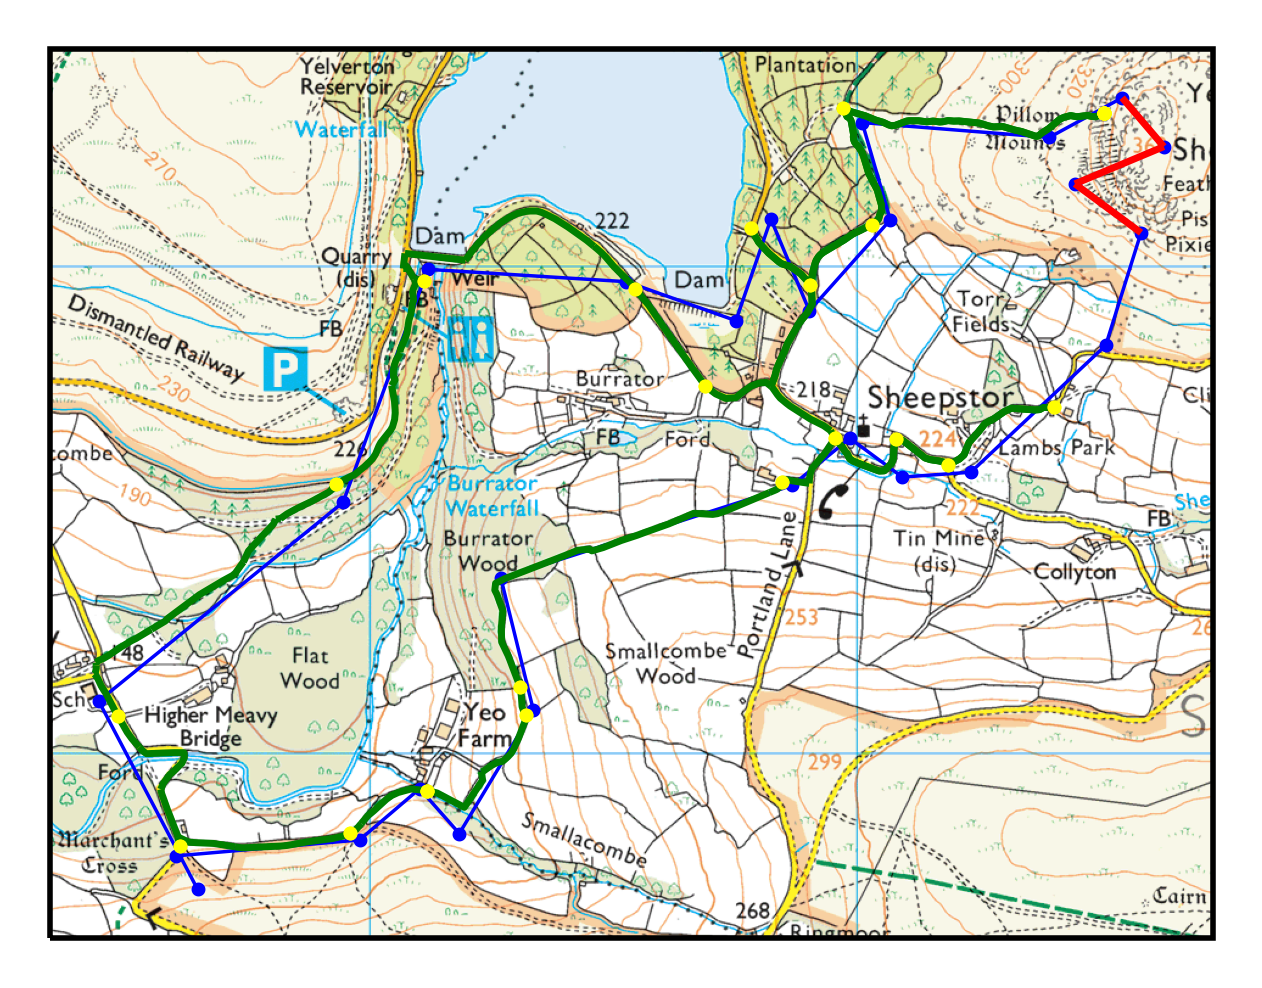

In [15]:
plot_global_map(sheepstor_map, global_nodes_gpd, coords,
                bluebell_walk, path_network, path_nodes, global_path_gpd, top_right, bottom_left,
                global_missing_links_gpd)